Adapted in notebook time_series_gp_s+l_noisy_pulse_eb_1:
- Use data file sim_noisy_pulse_eb.lc
- Add an uncorrelated error measurement component
- Use two SHO kernels

In [1]:
import math
%load_ext autoreload
%autoreload 2

import numpy as np
np.random.seed(0)

# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from spleaf import cov, term
from scipy.optimize import fmin_l_bfgs_b

import pandas as pd
pd.set_option('precision', 0)
pd.set_option('display.float_format', lambda x: '%.16f' % x)

In [2]:
# Make the notebook use the whole screen width
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

Read the first time series

In [3]:
df = pd.read_csv("../data/sim_noisy_pulse_eb.lc",sep=' ', header = None, names=['Time', 'Lc'], index_col=False, float_precision='round_trip')
df.dtypes

Time    float64
Lc      float64
dtype: object

In [4]:
# Print first and last lines of the dataset
#df.style.format('{:.16f}')
#df

In [5]:
X, Y = df['Time'].tolist(), df['Lc'].tolist()
X, Y = np.array(X), np.array(Y)

# 1. Exploratory
## Plot the data

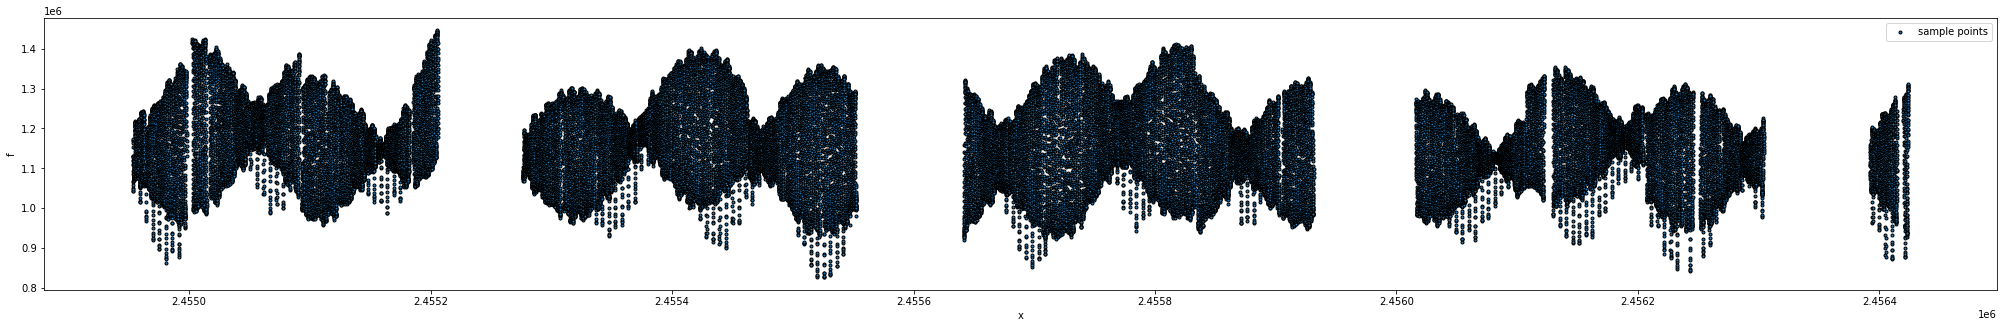

In [6]:
# Setup our figure environment
plt.figure(figsize=(35, 5))

# Plot observations
plt.plot(X, Y, ".", mew=1, linewidth=1, mec="black")

# Annotate plot
plt.xlabel("x"), plt.ylabel("f")
plt.legend(labels=["sample points"]);

## Downsample

In [7]:
# Need to reduce further to 12800 points as N//4 doesn't work
X_part, Y_part = X[1::4][:12800], Y[1::4][:12800]
N_sampled = X_part.shape[0]   # Use a number that can be divided by 4. N//4
N_sampled

12800

Select a subset for training the kernel

In [8]:
N_part = N_sampled

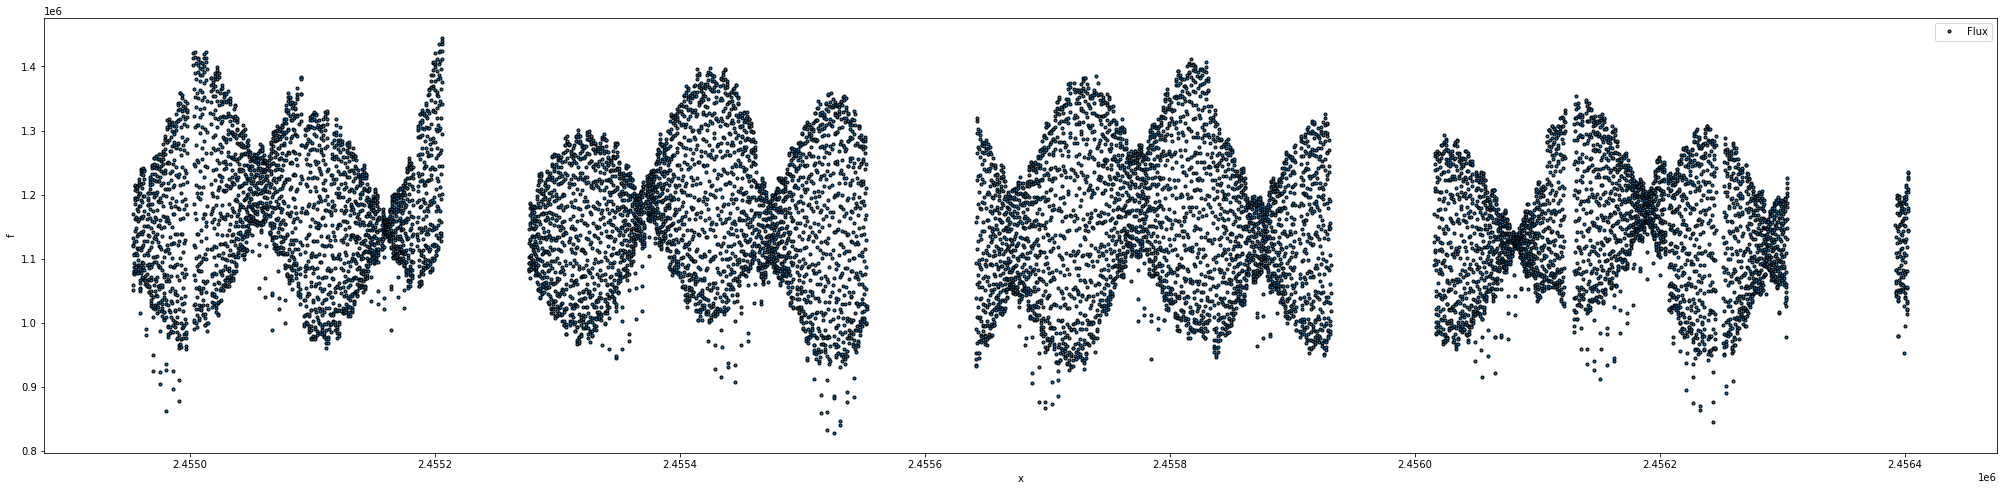

In [9]:
# Setup our figure environment
plt.figure(figsize=(35, 8))

# Plot observations
plt.plot(X_part, Y_part, ".", mew=1, linewidth=1, mec="black")

# Annotate plot
plt.xlabel("x"), plt.ylabel("f")
plt.legend(labels=["Flux"]);

# 2. Processing


Compose a Gaussian Process from a reasonable guess of kernels

In [10]:
def plot_kernel_samples(covariance_matrix, nr_of_samples=5):
    plt.figure(figsize=(35, 8))
    Y_sample = covariance_matrix.sample(nr_of_samples)
    N = cov_matrix.W.shape[0]
    for i in range(nr_of_samples):
        plt.plot(range(N), Y_sample[i])

def plot_kernel(covariance_matrix):
    # Our sample space
    X = np.linspace(-5., 5., 250)[:, None]
    C = covariance_matrix.chi2(X)
      
    # Visualise covariance matrix on right hand side
    plt.pcolor(X.T, X, C)
    # Annotate plot
    plt.gca().invert_yaxis(), plt.gca().axis("image")
    plt.colorbar()
    
def plot_series(data_x, data_y, smooth_x=None, smooth_y=None, var=None):
    # Plot
    plt.figure(figsize=(35, 8))
    plt.plot(data_x, data_y, ".", mew=1, linewidth=1, mec="black", label='truth')
    #plt.plot(tsmooth, ysignal, 'r', label='truth')
    #plt.errorbar(t, y, yerr, fmt='.', color='k', label='meas.')
    if not smooth_x is None:
        plt.fill_between(smooth_x, smooth_y-np.sqrt(var), smooth_y+np.sqrt(var), color='g', alpha=0.5)
        plt.plot(smooth_x, smooth_y, 'r', label='predict.')
    plt.xlabel('t')
    plt.ylabel('y')
    plt.legend()

In [11]:
# Predict evenly spaced points on our time-axis
X_part_smooth = np.linspace(X_part.min(), X_part.max(), N_part)

In [12]:
# Define the function to minimize
def negloglike(x, y, cov_matrix, params_to_fit):
   cov_matrix.set_param(x, params_to_fit)
   nll = -cov_matrix.loglike(y)
   # gradient
   nll_grad = -cov_matrix.loglike_grad()[1]
   return(nll, nll_grad)

In [13]:
# Initialize the S+LEAF model

# Two stochastically-driven harmonic oscillator
# One Uncorrelated measurement errors (yerr)
# Calibration errors (correlated noise)
#calib_id = (t//1).astype(int) # One calibration per day
#caliberr = np.random.uniform(0.5, 1.5, calib_id[-1]+1)
#yerr_calib = caliberr[calib_id]

cov_matrix = cov.Cov(X_part,
   err = term.Error(1),
   sho = term.SHOKernel(sig=-0.04314, P0=1.7474, Q=8019.36505),
   sho2 = term.SHOKernel(sig=-0.04314, P0=1.0, Q=8019.36505))
#   calerr = term.CalibrationError(calib_id, yerr_calib),

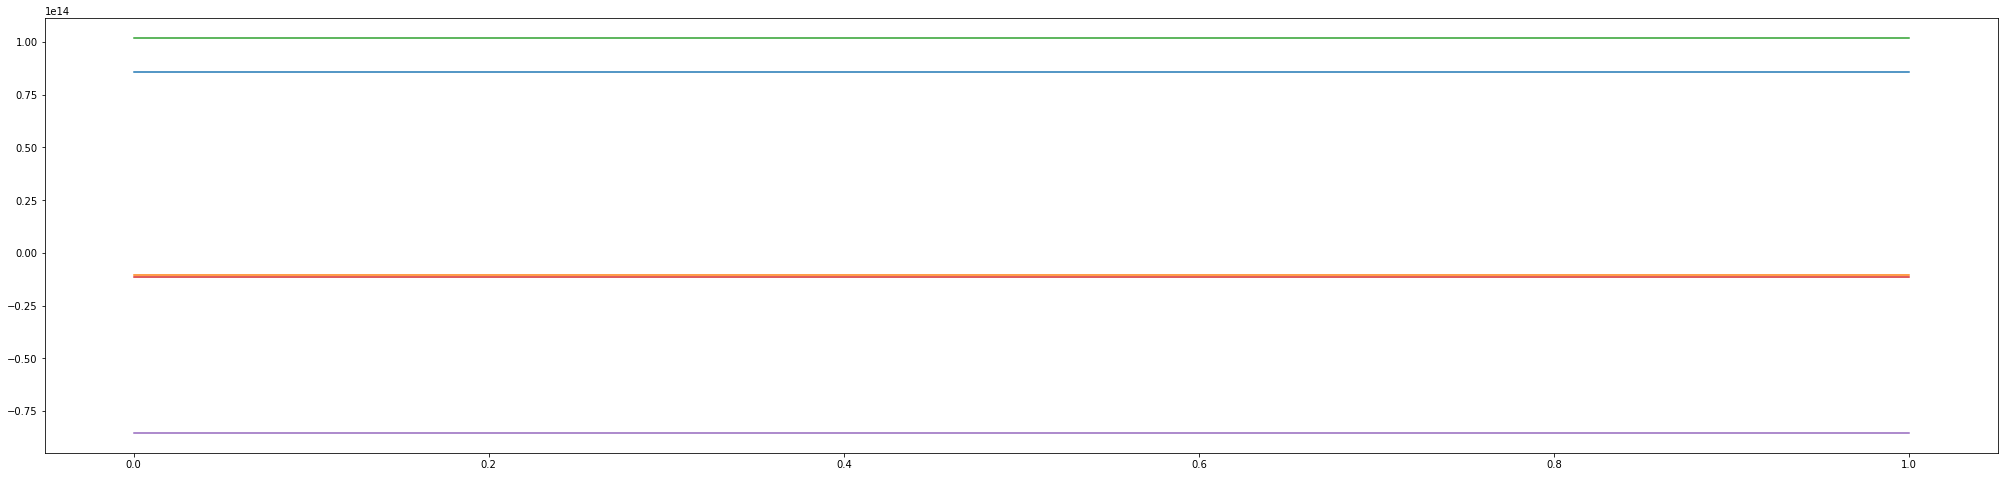

In [22]:
plot_kernel_samples(cov_matrix)

In [14]:
# List of parameters to fit: all (for now)
params_to_fit = cov_matrix.param

# We now fit the hyperparameters using the fmin_l_bfgs_b function from scipy.optimize.
xbest,_,_ = fmin_l_bfgs_b(negloglike, cov_matrix.get_param(), args=(Y_part, cov_matrix, params_to_fit))

# We now use S+LEAF to predict the missing data on the training data scope
cov_matrix.set_param(xbest, params_to_fit)
mu_part_smooth, var_part_smooth = cov_matrix.conditional(Y_part, X_part_smooth, calc_cov='diag')

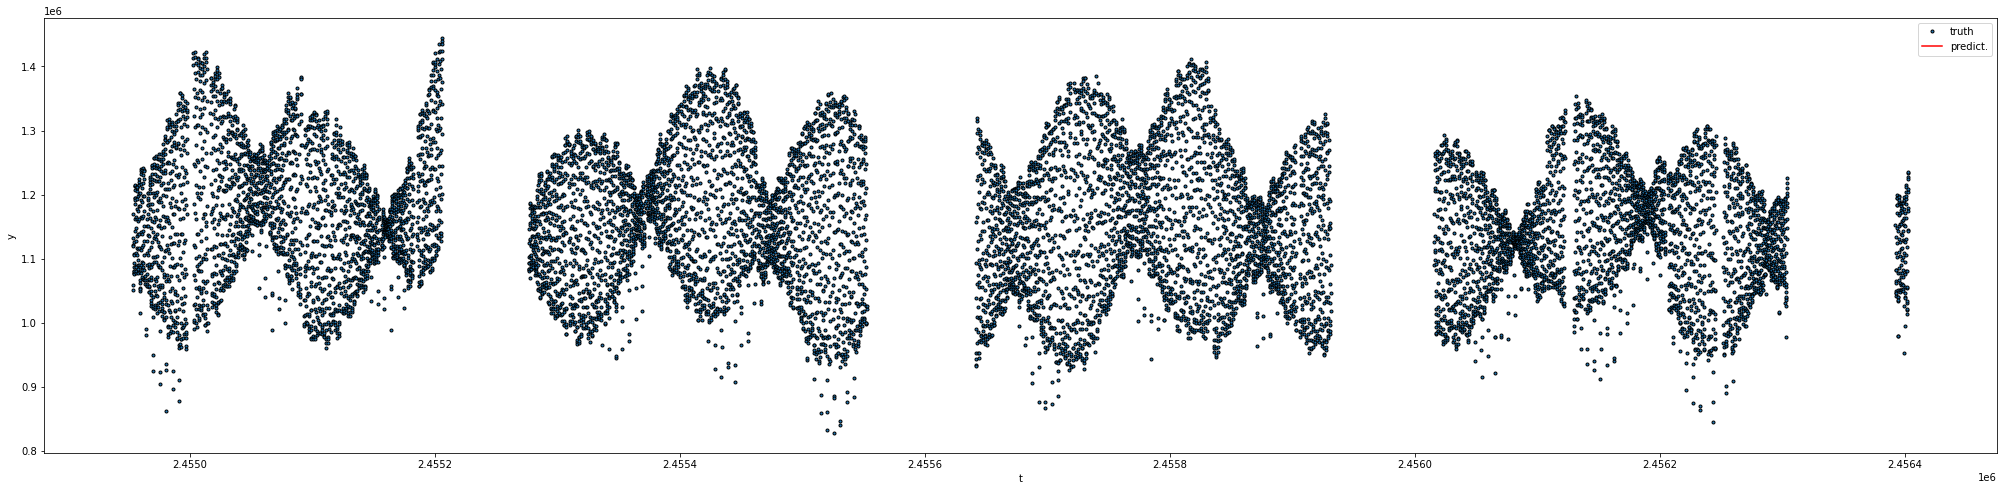

In [15]:
plot_series(X_part, Y_part, X_part_smooth, mu_part_smooth, var_part_smooth)

## Explore the parameters of the fitted model

In [16]:
cov_matrix.param

['sho.sig', 'sho.P0', 'sho.Q', 'sho2.sig', 'sho2.P0', 'sho2.Q']

In [17]:
sho_kern = cov_matrix.kernel['sho']
sho_kern

In [18]:
cov_matrix.get_param('sho.sig'), cov_matrix.get_param('sho.P0'), cov_matrix.get_param('sho.Q')

(-45362269820560.734, 5627457102760.648, -14248099747902.672)

In [19]:
cov_matrix.get_param('sho2.sig'), cov_matrix.get_param('sho.P0'), cov_matrix.get_param('sho2.Q')

(-17176379430562.926, 5627457102760.648, -1984185348924.828)

## Model Evaluation

RMSE

In [20]:
mu_part, var_part = cov_matrix.conditional(Y_part, X_part, calc_cov='diag')

np.sqrt(np.nanmean((mu_part-Y_part)**2))

nan

RMSE per x

In [21]:
np.sqrt(np.nanmean((mu_part-Y_part)**2))/N_part

nan